In [48]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import threading
import pygame
import random
import mido
import math
import os

class Boid:
  def __init__(self, x, y):
    self.acceleration = vec2(0, 0)
    angle = random.uniform(0, 2*math.pi)
    self.velocity = vec2(math.cos(angle), math.sin(angle))
    self.position = vec2(x, y)
    self.r = 2.0
    self.max_velocity = 2
    self.max_acceleration = 0.03
  
  def seek(self, target):
    desired = target - self.position
    desired = desired.normalized()
    desired *= self.max_velocity
    steer = desired - self.velocity
    steer = steer.limited(self.max_acceleration)
    return steer
  
  # Wraparound
  def borders(self):
    x, y = self.position
    x = (x+self.width) % self.width
    y = (y+self.height) % self.height
    self.position = vec2(x,y)
  
  # Separation: Method checks for nearby boids and steers away
  def separate(self, boids):
    desired_separation = 25.0
    steer = vec2(0, 0)
    count = 0
    # For every boid in the system, check if it's too close
    for other in boids:
      d = (self.position - other.position).length()
      # If the distance is greater than 0 and less than an arbitrary
      # amount (0 when you are yourself)
      if 0 < d < desired_separation:
        # Calculate vector pointing away from neighbor
        diff = self.position - other.position
        diff = diff.normalized()
        steer += diff/d  # Weight by distance
        count += 1     # Keep track of how many
    # Average - divide by how many
    if count > 0:
      steer /= count
    # As long as the vector is greater than 0
    if steer.length() > 0:
      # Implement Reynolds: Steering = Desired - Velocity
      steer = steer.normalized()
      steer *= self.max_velocity
      steer -= self.velocity
      steer = steer.limited(self.max_acceleration)
    return steer
  
  # Alignment: For every nearby boid in the system, calculate the average velocity
  def align(self, boids):
    neighbor_dist = 50
    sum = vec2(0, 0)
    count = 0
    for other in boids:
      d = (self.position - other.position).length()
      if 0 < d < neighbor_dist:
        sum += other.velocity
        count += 1
    if count > 0:
      sum /= count
      # Implement Reynolds: Steering = Desired - Velocity
      sum = sum.normalized()
      sum *= self.max_velocity
      steer = sum - self.velocity
      steer = steer.limited(self.max_acceleration)
      return steer
    else:
      return vec2(0, 0)
  
  # Cohesion: For the average position (i.e. center) of all nearby boids, calculate
  # steering vector towards that position
  def cohesion(self, boids):
    neighbor_dist = 50
    sum = vec2(0, 0)  # Start with empty vector to accumulate all positions
    count = 0
    for other in boids:
      d = (self.position - other.position).length()
      if 0 < d < neighbor_dist:
        sum += other.position  # Add position
        count += 1
    if count > 0:
      sum /= count
      return self.seek(sum)
    else:
      return vec2(0, 0)
  
  def flock(self, boids):
    sep = self.separate(boids)  # Separation
    ali = self.align(boids)  # Alignment
    coh = self.cohesion(boids)  # Cohesion
    # Arbitrarily weight these forces
    sep *= 1.5
    ali *= 1.0
    coh *= 1.0
    # Add the force vectors to acceleration
    self.acceleration += sep
    self.acceleration += ali
    self.acceleration += coh
  
  def update(self):
    # Update velocity
    self.velocity += self.acceleration
    # Limit speed
    self.velocity = self.velocity.limited(self.max_velocity)
    self.position += self.velocity
    # Reset acceleration to 0 each cycle
    self.acceleration = vec2(0, 0)
  
  def run(self, boids):
    self.flock(boids)
    self.update()
    self.borders()

class Flock:
  def __init__(self, count=150, width=640, height=360):
    self.width = width
    self.height = height
    self.boids = []
    for i in range(count):
      boid = Boid(width/2, height/2)
      boid.width = width
      boid.height = height
      self.boids.append(boid)
  
  def run(self):
    for boid in self.boids:
      boid.run(self.boids)
  
  def cohesion(self, boids):
    P = np.zeros((len(boids),2))
    for i, boid in enumerate(self.boids):
      P[i] = boid.cohesion(self.boids)
    return P
##
# Helpers
##

def struct(name, members):
  cls = namedtuple(name, members)
  cls.__repr__ = lambda self: "%s(%s)" % (name, ','.join(str(s) for s in self))
  return cls

class vec2(struct('vec2', ('x', 'y'))):
  def __add__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x+other.x, self.y+other.y)
    return vec2(self.x+other, self.y+other)
  
  def __sub__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x-other.x, self.y-other.y)
    return vec2(self.x-other, self.y-other)
  
  def __mul__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x*other.x, self.y*other.y)
    return vec2(self.x*other, self.y*other)
  
  def __truediv__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x/other.x, self.y/other.y)
    return vec2(self.x/other, self.y/other)
  
  def length(self):
    return math.hypot(self.x, self.y)
  
  def normalized(self):
    length = self.length()
    if not length:
      length = 1.0
    return vec2(self.x/length, self.y/length)
  
  def limited(self, maxlength=1.0):
    length = self.length()
    if length > maxlength:
      return vec2(maxlength*self.x/length, maxlength*self.y/length)
    return self

##
# Midi
##

def play_midi(arg):
  '''Stream `arg` (midi file path or mido.midifile)'''
  tmp = None
  if isinstance(arg, mido.midifiles.midifiles.MidiFile):
    tmp = 'temp-{}.mid'.format(random.randint(0, 2**64))
    arg.save(tmp)
    path = tmp
  else:
    path = arg
  # play the audio
  freq = 44100     # audio CD quality
  bitsize = -16    # unsigned 16 bit
  channels = 2     # 1 is mono, 2 is stereo
  n_samples = 1024 # number of samples
  pygame.mixer.init(freq, bitsize, channels, n_samples)
  pygame.mixer.music.set_volume(0.8) # optional volume 0 to 1.0
  # play the clip
  try:
    clock = pygame.time.Clock()
    pygame.mixer.music.load(path)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
      clock.tick(30) # check if playback has finished
  except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
  if tmp: os.remove(tmp)
  return arg

##
# Config
##

n = 50 # number of boids
flock = Flock(n) # boid Flock
P = np.zeros((n,2)) # positions in one frame
l = [] # positions across all frames
domains = {'x': [0, 640], 'y': [0, 360]} # domains to use in x, y dimensions

In [ ]:
# create a sequence of flock steps
for i in range(10000):
  flock.run()
  P = np.zeros((n,2)) # positions in one frame
  for idx, boid in enumerate(flock.boids): P[idx] = boid.position
  l.append(P)

In [2]:
if False:
  flock_arr = np.array(l)
  np.save('flock-simulation', flock_arr)
else:
  flock_arr = np.load('flock-simulation.npy')

# Pitch Grid

In [3]:
import random
import numpy as np

# identify available pitch steps within chromatic scale
base_steps = [0, 2, 4, 5, 7, 9, 11]
steps = []
for octave in [3,4,5]:
  steps += [i+(octave*12) for i in base_steps]

# identify the number of distinct pitches in each dimension
n_x_stops = 10
n_y_stops = 10

# quantize out a grid
x_stops = np.linspace(domains['x'][0], domains['x'][1], num=n_x_stops, endpoint=False)
y_stops = np.linspace(domains['y'][0], domains['y'][1], num=n_y_stops, endpoint=False)

# create the coordinate grid
coord_grid = np.array(np.meshgrid(x_stops, y_stops)).T

# create the grid of pitch steps
pitch_grid = np.zeros((n_x_stops, n_y_stops))
kdx = 0
for idx, i in enumerate(pitch_grid):
  for jdx, j in enumerate(i):
    pitch_grid[idx, jdx] = steps[kdx]
    kdx = kdx+1
    if kdx >= len(steps): kdx = 0
pitch_grid = pitch_grid.astype('int')

In [ ]:
print(steps)

In [ ]:
pitch_grid

# Random simulation

In [ ]:
from collections import defaultdict

m = mido.MidiFile()
m.tracks.append(mido.MidiTrack())

time_scalar = 120 # beats per unit in i
times = {i: 0 for i in steps} # d[note] = time the note was pressed
pressed = {i: False for i in steps} # d[note] = pressed or not

# store all times in absolute coords
for i in range(10): # n frames of time
  new_notes = [random.choice(steps) for _ in range(random.choice([2,3,4]))]
  # end each played note that's not in the new notes
  for note in pressed:
    if not pressed[note]: continue
    if note not in new_notes:
      m.tracks[0].append( mido.Message('note_off', note=note, time=i*time_scalar) )
      pressed[note] = False
  # add the new notes
  for note in new_notes:
    if not pressed[note]:
      pressed[note] = True
      times[note] = i
      m.tracks[0].append( mido.Message('note_on', note=note, time=i*time_scalar) )
      
# convert times to relative offsets
last_time = 0
for i in m.tracks[0]:
  t = i.time
  i.time = i.time - last_time
  last_time = t
  
# save and play the midi
play_midi(m)
m.save('random.mid')

# Flock simulation

In [5]:
from sklearn.cluster import KMeans
from collections import defaultdict

m = mido.MidiFile()
m.tracks.append(mido.MidiTrack())

step = 1 # how often to sample frames
time_scalar = 1200 # beats per unit in i
times = {i: 0 for i in steps} # d[note] = time the note was pressed
pressed = {i: False for i in steps} # d[note] = pressed or not
positions = [] # [[list of x,y positions in pitch space for frame]]

# store all times in absolute coords
flock_arr = np.load('flock-simulation.npy')
for idx, i in enumerate(flock_arr): # time
  if idx % step != 0: continue
  model = KMeans(n_clusters=3).fit(i)
  frame_centroids = model.cluster_centers_
  # convert the k flock centroid positions to notes
  frame_notes = []
  frame_positions = []
  for x, y in frame_centroids:
    # find the index offsets of x, y in the coords grid
    x_pos = np.where(x_stops < x)[0][-1]
    y_pos = np.where(y_stops < y)[0][-1]
    # get the pitch that corresponds with the centroid
    frame_notes.append( pitch_grid[x_pos, y_pos] )
    frame_positions.append([x_pos, y_pos])
  positions.append(frame_positions)
  # end each played note that's not in the new notes
  for note in pressed:
    if not pressed[note]: continue
    if note not in frame_notes:
      m.tracks[0].append( mido.Message('note_off', note=note, time=idx*time_scalar) )
      pressed[note] = False
  # add the new notes
  for note in frame_notes:
    if not pressed[note]:
      pressed[note] = True
      times[note] = idx
      m.tracks[0].append( mido.Message('note_on', note=note, time=idx*time_scalar) )
# close all open notes
for note in pressed:
  if not pressed[note]: continue
  m.tracks[0].append( mido.Message('note_off', note=note, time=idx*time_scalar) )
      
# convert times to relative offsets
last_time = 0
for i in m.tracks[0]:
  t = i.time
  i.time = i.time - last_time
  last_time = t

In [54]:
# set tempo and save
if False:
  m.tracks[0].insert(0, mido.MetaMessage('set_tempo', tempo=990))
  m.ticks_per_beat = 300
  m.save('flock.mid')

m = mido.MidiFile('og-flock.mid')
m.ticks_per_beat = 10000
for i in m:
  i.time *= 0.25
m.save('flock.mid')
  
os.system('open flock.mid')
  
# convert to mp3
if os.path.exists('flock.mp3'): os.remove('flock.mp3')
os.system('timidity flock.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k flock.mp3')

0

# Visualize the boid flock movement

[]

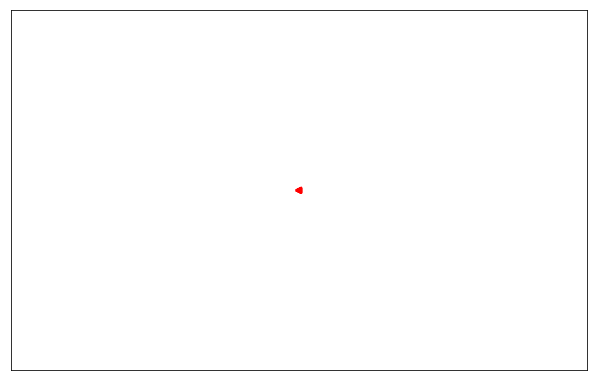

In [29]:
# visualize the raw sequence - one point per boid
def update(time):
  scatter.set_offsets(flock_arr[time])

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=True)
scatter = ax.scatter(P[:,0], P[:,1], s=30, facecolor='red', edgecolor='None', alpha=0.5, marker='<')

# interval = time between frames in milliseconds
boid_animation = FuncAnimation(fig, update, interval=30, frames=len(flock_arr))
ax.set_xlim(*domains['x'])
ax.set_ylim(*domains['y'])
ax.set_xticks([])
ax.set_yticks([])

#HTML(boid_animation.to_html5_video())

In [31]:
# save the animation
boid_animation.save('boid-animation.mp4', fps=20)

# Visualize the centroid movement

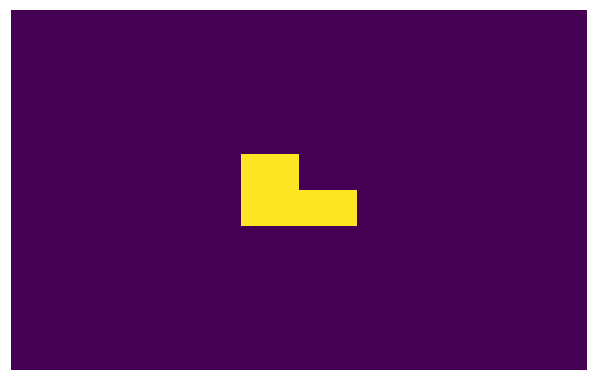

In [46]:
def get_frame_array(frame_idx):
  f = np.zeros((n_x_stops, n_y_stops))
  for x,y in p[frame_idx]: 
    f[n_y_stops-y-1, x] = 1 # set the centroid boxes to 1, invert y axis
  return f

def update(i):
  im.set_array(get_frame_array(i))

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False, xticks=[], yticks=[])

p = np.array(positions)
im = ax.imshow(get_frame_array(0))

# interval = time between frames in milliseconds
centroid_animation = FuncAnimation(fig, update, interval=30, frames=len(positions))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('auto')

#HTML(centroid_animation.to_html5_video())

In [47]:
# save the animation
centroid_animation.save('centroid-animation.mp4', fps=20)

# Stack animations

In [ ]:
os.system('ffmpeg -y -i boid-animation.mp4 -i centroid-animation.mp4 -filter_complex "[1:v][0:v]scale2ref[ua][b];[ua]setsar=1,format=yuva444p,colorchannelmixer=aa=0.5[u];[b][u]overlay=eof_action=pass[v]" -map [v] stacked-animation.mp4')

# Combine animations with audio

In [68]:
import subprocess

def get_file_duration(filename):
  result = subprocess.check_output('ffprobe -show_entries format=duration -i {}'.format(filename), shell=True)
  seconds = float(str(result).split('duration=')[1].split('\\n')[0])
  return seconds
  
audio_seconds = get_file_duration('flocking.mp3')
video_seconds = get_file_duration('stacked-animation.mp4')

# stretch the video duration
ratio = audio_seconds / video_seconds
os.system('ffmpeg -i stacked-animation.mp4 -filter_complex "setpts=PTS*{}" stretched.mp4'.format(ratio))

# combine the audio and video
os.system('ffmpeg -i flock.mp3 -i stretched.mp4 combined.mp4')

0

# Streaming midi

In [ ]:
import mido
from mido.backends import rtmidi # one must import the backend before it's available

mido.set_backend('mido.backends.rtmidi', load=True)
out_port = mido.open_output('mido_port')

print(portmidi.get_devices())
print(mido.get_output_names())

msg = mido.Message('note_on', note=60)
out_port.send(msg)